In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import MD_AE_tools.mode_decomposition as md
import myplot
import configparser
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.set_visible_devices([], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)


In [8]:
# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs

In [9]:
#================= autoencoder data ========================
results_folder = 'MD_10__2022_05_21__17_29_44'
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']
folder = system_info['save_location'] + '/' + results_folder + '/'

filename = folder + 'results.h5'
hf = h5py.File(filename,'r')
decomp_test = np.array(hf.get('modes_test'))
u_avg = np.array(hf.get('u_avg_test'))
hf.close()
print("Finished loading data.")
[latent_dim,nt,ny,nz,nu] = decomp_test.shape
print(latent_dim,nt,ny,nz,nu)

# myplot.plot_ae_modes(decomp_test,[5,9,4,8,7,3,1,6,2,0],snapshot=300)# 

Finished loading data.
10 600 21 24 2


(10, 1500, 21, 24)


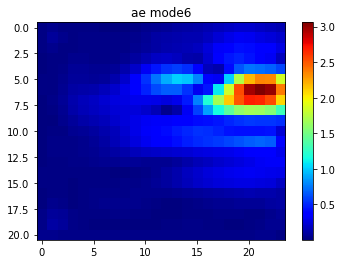

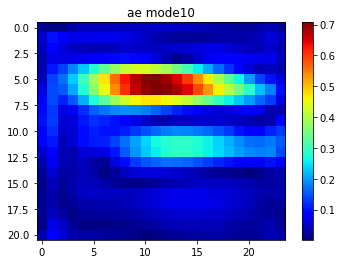

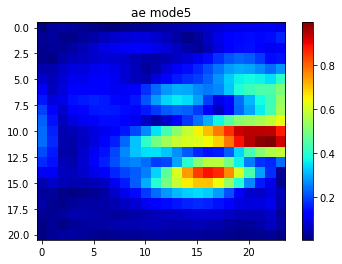

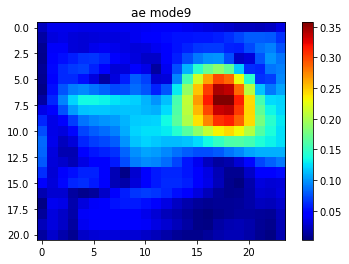

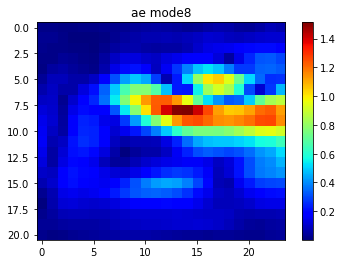

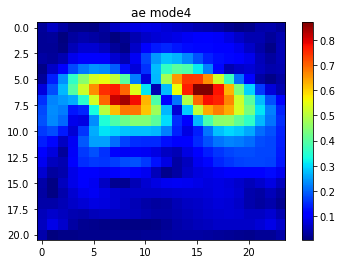

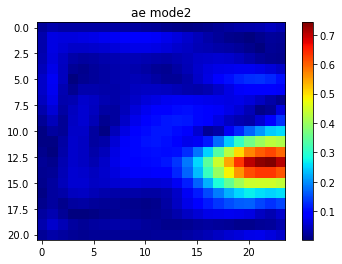

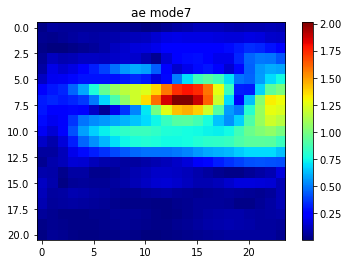

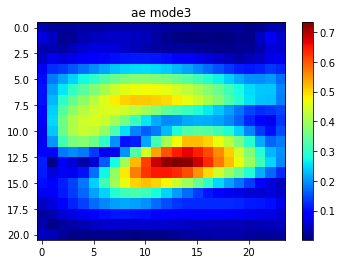

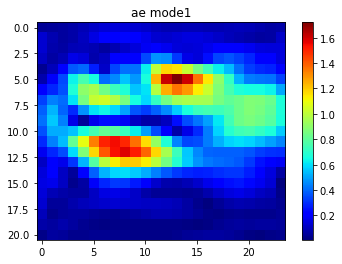

In [5]:
# magnitude
modes_V = np.sum(decomp_test**2,axis=-1)**0.5
print(modes_V.shape)

for i in [5,9,4,8,7,3,1,6,2,0]: 
    # print(i)
    # print(type(i))
    plt.figure()
    title = 'ae mode' + str(i+1)
    plt.title(title)
    plt.imshow(modes_V[i,0,:,:],cmap='jet')
    plt.colorbar()
    plt.show()

In [32]:
WhichDecoder = 3-1 # start from 0
vy = decomp_test[WhichDecoder,:,:,:,0].astype('float64')
vy = np.transpose(vy,[1,2,0])
vz = decomp_test[WhichDecoder,:,:,:,1].astype('float64')
vz = np.transpose(vz,[1,2,0]) #(ny,nz,nt)
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
print(X.shape)

(42, 24, 1500)


## POD

In [33]:
pod = md.POD(X,method='classic')
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean

Calculating POD ...
User has selected classic POD
POD done.


/home/ym917/Documents/Codes/MD-CNN-AE/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


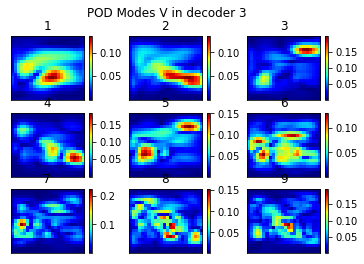

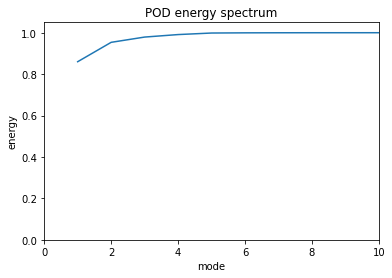

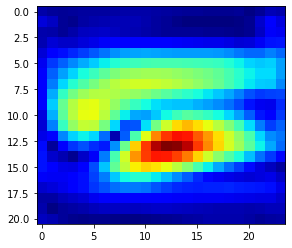

classic
[0.85998732 0.95355784 0.97898255 0.9910528  0.99849248 0.99941943
 0.99976603 0.99989971]


In [36]:
#======================= plot ==========================

## Modes
PlotWhichVelocity = 'V' 
save_img = False

fig = plt.figure(1)
title = "POD Modes " + PlotWhichVelocity + " in decoder " + str(WhichDecoder+1)
# title = "POD Modes "+PlotWhichVelocity
plt.suptitle(title)
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    if PlotWhichVelocity == 'w': # Q was built [vz,vy]
        pltV = pltV[0:ny,:]
    elif PlotWhichVelocity == 'v':
        pltV = pltV[ny:,:]
    elif PlotWhichVelocity == 'V':
        pltV = (pltV[0:ny,:]**2 + pltV[ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
if save_img:
    p = folder + "POD_modes_" + str(WhichDecoder+1) + PlotWhichVelocity + ".png"
    plt.savefig(p)
else:
    plt.show()

## Spectrum
energy = np.cumsum(lam/np.sum(lam))
plt.figure()
plt.title('POD energy spectrum')
plt.plot(np.arange(len(energy))+1,energy)
plt.ylabel('energy')
plt.xlabel('mode')
plt.xlim([0,10])
plt.ylim([0,1.05])
if save_img:
    p = folder + "POD_spectrum_" + str(WhichDecoder+1) + ".png"
    plt.savefig(p)
else:
    plt.show()

## Reconstruct
rebuildv = pod.reconstruct(number_of_modes=2,shape=[2,ny,nz,nt])
if PlotWhichVelocity == 'w': # Q was built [vz,vy]
    rebuildv = rebuildv[0,:,:,0]
elif PlotWhichVelocity == 'v':
    rebuildv = rebuildv[1,:,:,0]
elif PlotWhichVelocity =='V':
    rebuildv = (rebuildv[0,:,:,0]**2 + rebuildv[1,:,:,0]**2)**0.5
plt.figure()
plt.imshow(rebuildv.real,'jet')
plt.show()
print(pod.typePOD)
print(energy[:8])

## DMD

In [ ]:
dmd = md.DMD(X[:,:,:-1],X[:,:,1:],r=50,keep_shape=True)
Phi, Lambda, b = dmd.get_modes()
print(Phi.shape,Lambda.shape,b.shape)

In [ ]:
#======================== Plot Mode =========================
mode_z = Phi[:ny,:,:].real # X was built vstack(vz,vy)
mode_y = Phi[ny:,:,:].real # has shape [ny,nz,modes]

whichmode = 0
whichvelocity = 'v'
save_img = False
# plot mean flow (b = 1.0)
# plt.figure()
# if whichvelocity == 'w':
#     plt.imshow(mode_z[:,:,whichmode],'jet')
# else:
#     plt.imshow(mode_y[:,:,whichmode],'jet')
# # plt.title('decoder '+str(WhichDecoder+1))
# plt.show()
# print(np.diag(Lambda)[whichmode])

plt.suptitle("DMD modes in decoder " + str(WhichDecoder+1) + ", " + whichvelocity)
# plt.suptitle("DMD modes "+ whichvelocity)
lam = np.diag(Lambda)
lam_r = np.abs(lam)
lam_f = np.angle(lam)/(2*np.pi)/dt
for i in range(9):
    title = str(i+1)+', a='+str(np.around(lam_r[i],decimals=2))+" f="+str(np.around(lam_f[i],1))
    ax = plt.subplot(3,3,i+1,title=title,xticks=[],yticks=[])
    if whichvelocity == 'w': # Q was built [vz,vy]
        pltV = mode_z[:,:,i]
    elif whichvelocity == 'v':
        pltV = mode_y[:,:,i]
    elif whichvelocity == 'V':
        pltV = (mode_z[:,:,i]**2 + mode_y[:,:,i]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
if save_img:
    p = folder + "DMD_modes_" + str(WhichDecoder+1) + whichvelocity + ".png"
    plt.savefig(p)
else:
    plt.show()


## eigenvalue plot, temporal behaviour
lam_r, lam_f = dmd.get_frequency(dt)
b_r = dmd.get_amplitude()
plt.figure()
plt.scatter(lam_f,lam_r,c=b_r,cmap='Blues',vmin=0,vmax=max(b_r))
plt.colorbar(label='|b|',ticks=[])
plt.xlabel('freqency')
plt.ylabel('|λ|')
plt.title('Eigenvalues')
plt.yticks([0,1])
# plt.hlines(1,0,360,colors='k',linestyles='dotted')
plt.xlim(left=0)
plt.show()

# ## plot amplitude
max_fq = max(lam_f)
plt.figure()
# plt.plot(lam_f_sorted,b_r_sorted)
plt.bar(lam_f,b_r,width=700/dmd.r)
plt.xlabel('freqency')
plt.ylabel('|b|')
plt.title('Amplitude, contribution')
# plt.xticks([])
plt.xlim(left=0)
plt.yticks([0])
if save_img:
    p = folder + "DMD_amp_" + str(WhichDecoder+1) + ".png"
    plt.savefig(p)
else:
    plt.show()

In [ ]:
np.max(np.abs(b_r))

In [ ]:
#==================== actual flow =========================
time = 0
PlotWhichVelocity = 'v'

v = vy[:,:,time]
w = vz[:,:,time]
V = (v**2 + w**2)**0.5

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.suptitle('Decoder '+str(WhichDecoder+1)+', velocity '+PlotWhichVelocity)
if PlotWhichVelocity == 'v':
    fig1 = ax1.imshow(v,'jet')
    fig2 = ax2.imshow(np.mean(vy,-1),'jet')
elif PlotWhichVelocity == 'w':
    ax1 = plt.imshow(w,'jet')
    ax2 = plt.imshow(np.mean(vz,-1),'jet')
elif PlotWhichVelocity == 'V':
    ax1= plt.imshow(V,'jet')
    ax2 = plt.imshow(np.mean(V,-1),'jet')
fig.colorbar(fig1,ax=ax1)
fig.colorbar(fig2,ax=ax2)
ax1.set_title('flow at time '+str(time))
ax2.set_title('time_averaged flow')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()


In [ ]:
first_modes = [5,1,9,8,4]#[5,9,4,8,7]
reconstructed = 0
for i in first_modes:
    reconstructed = reconstructed + decomp_test[i,:,:,:,:]
reconstructed = reconstructed[:,:,:,:] + u_avg
plt_reconstructed = (reconstructed[200,:,:,0]**2 + reconstructed[300,:,:,1]**2)**0.5
plt.figure()
plt.imshow(plt_reconstructed,cmap='jet')
plt.colorbar()
plt.show()

# X_recons = np.vstack((np.transpose(reconstructed[:,:,:,1],[1,2,0]),np.transpose(reconstructed[:,:,:,0],[1,2,0])))
# pod_recons = md.POD(X_recons,method='classic')
# Q_POD_re,lam_re = pod_recons.get_modes()
# print('energy in reconstructed field: ',np.sum(lam_re)/1013.8857143130634)

In [12]:
# number of POD modes to reach 99.99% energy in the POD modes
a = []
to99 = np.zeros(latent_dim,dtype='int')
for i in range(latent_dim):
    vy = decomp_test[i,:,:,:,0].astype('float64')
    vy = np.transpose(vy,[1,2,0])
    vz = decomp_test[i,:,:,:,1].astype('float64')
    vz = np.transpose(vz,[1,2,0]) #(ny,nz,nt)
    X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
    pod = md.POD(X,method='classic')
    Q_POD,lam = pod.get_modes()
    energy = np.cumsum(lam/np.sum(lam))
    a.append(energy[0])
    for j in range(len(energy)):
        if energy[j] >= 0.9999:
            to99[i] = j+1
            break
print(to99)
sort_idx = np.argsort(to99)
rank_to99 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print(rank_to99)

Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
[6 4 5 5 6 5 4 4 4 5]
[ 5  1 10  6  4  3  9  8  7  2]


In [18]:
a

[0.9656325905831444,
 0.9916078867081383,
 0.9474421761242621,
 0.9812311668453912,
 0.9706888423030464,
 0.9703593450309516,
 0.9876903266223706,
 0.9832694576507617,
 0.9897139623779423,
 0.9830826457844528]

In [17]:
print(np.argsort(a)+1)

[ 3  1  6  5  4 10  8  7  9  2]
